In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
print(torch.__version__)

2.2.1


In [3]:
# Set font to match Latex
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
})

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())


In [5]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [6]:
train_image = []
train_target = []

for data in mnist_trainset:
    image, target = data
    train_image.append(image)
    train_target.append(target)

In [7]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
test_image = []
test_target = []

for data in mnist_testset:
    image, target = data
    test_image.append(image)
    test_target.append(target)

7


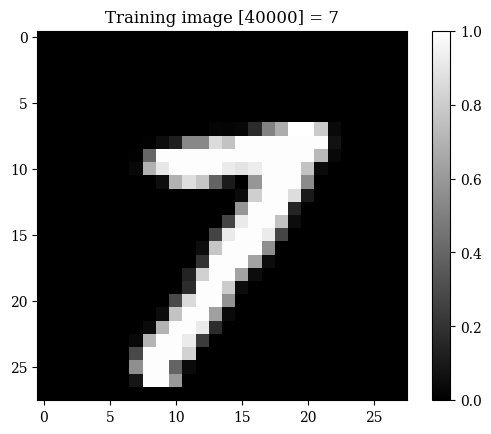

In [10]:
print(train_target[40000])
plt.imshow(train_image[40000].view(28,28), cmap='gray')
plt.colorbar()
plt.title('Training image [' + str(40000) + '] = ' + str(train_target[40000]))
plt.savefig('trainDataSetnr.pdf')

9


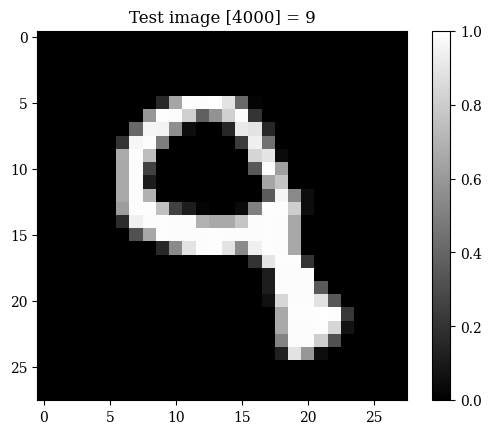

In [11]:
print(test_target[4000])
plt.imshow(test_image[4000].view(28,28), cmap='gray')
plt.colorbar()
plt.title('Test image [' + str(4000) + '] = ' + str(test_target[4000]))
plt.savefig('testDataSetnr.pdf')

## Problem Two: Singel Hidden Layer

In [12]:
# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters 
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 500  # Size of the hidden layer
num_classes = 10 # Number of unique classes the model should be able to predict
num_epochs = 10
batch_size = 100
learning_rate = 0.01

train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_testset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Fully connected FeedForward network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model, loss function, optimizer
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss() #measures deviation between predicted and actual classes
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


# Tracking accuracy and loss
accuracy_history = []
loss_history = []

# Training Loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation accuracy after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2f}%')
    accuracy_history.append(accuracy)
    loss_history.append(loss.item()) 

Epoch: 1, Loss: 0.8981, Validation Accuracy: 84.54%
Epoch: 2, Loss: 0.5634, Validation Accuracy: 88.08%
Epoch: 3, Loss: 0.6016, Validation Accuracy: 89.41%
Epoch: 4, Loss: 0.4127, Validation Accuracy: 90.14%
Epoch: 5, Loss: 0.3693, Validation Accuracy: 90.68%
Epoch: 6, Loss: 0.2065, Validation Accuracy: 91.04%
Epoch: 7, Loss: 0.2647, Validation Accuracy: 91.46%
Epoch: 8, Loss: 0.1734, Validation Accuracy: 91.87%
Epoch: 9, Loss: 0.4223, Validation Accuracy: 92.06%
Epoch: 10, Loss: 0.2124, Validation Accuracy: 92.26%


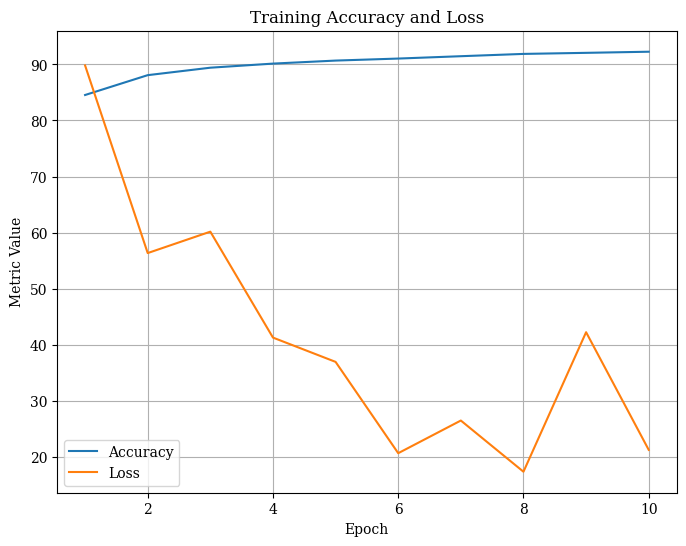

In [13]:
# Create the dataframe
df_metrics = pd.DataFrame({'Epoch': range(1, num_epochs + 1), 
                   'Accuracy': accuracy_history,
                   'Loss': loss_history})

# Plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(df_metrics['Epoch'], df_metrics['Accuracy'], label='Accuracy')
plt.plot(df_metrics['Epoch'], df_metrics['Loss']*100, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.grid(True) 
plt.show()

## Problem 3

In [14]:
# Hyperparameters 
input_size = 784
hidden_size_1 = 500  # Size of the first hidden layer
hidden_size_2 = 300  # Size of the second hidden layer
num_classes = 10
num_epochs = 40  # Train for more epochs
batch_size = 100
learning_rate = 0.01
weight_decay = 0.001  # L2 regularization strength

In [15]:
# Fully connected neural network with two hidden layers
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(NeuralNet2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_size_2, num_classes)  # Output layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)  # Pass through the second hidden layer
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Model, loss function, optimizer (with L2 regularization)
model = NeuralNet2(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [16]:
# Tracking accuracy and loss
accuracy_history2 = []
loss_history2 = []

# Training Loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation accuracy after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2f}%')
    accuracy_history2.append(accuracy)
    loss_history2.append(loss.item())   

Epoch: 1, Loss: 1.3284, Validation Accuracy: 74.10%
Epoch: 2, Loss: 0.4873, Validation Accuracy: 86.47%
Epoch: 3, Loss: 0.4644, Validation Accuracy: 88.91%
Epoch: 4, Loss: 0.2370, Validation Accuracy: 89.96%
Epoch: 5, Loss: 0.5797, Validation Accuracy: 90.69%
Epoch: 6, Loss: 0.3777, Validation Accuracy: 91.17%
Epoch: 7, Loss: 0.1514, Validation Accuracy: 91.67%
Epoch: 8, Loss: 0.3520, Validation Accuracy: 91.99%
Epoch: 9, Loss: 0.3254, Validation Accuracy: 92.43%
Epoch: 10, Loss: 0.1852, Validation Accuracy: 92.82%
Epoch: 11, Loss: 0.2257, Validation Accuracy: 93.01%
Epoch: 12, Loss: 0.1828, Validation Accuracy: 93.14%
Epoch: 13, Loss: 0.2628, Validation Accuracy: 93.36%
Epoch: 14, Loss: 0.1530, Validation Accuracy: 93.63%
Epoch: 15, Loss: 0.1310, Validation Accuracy: 93.86%
Epoch: 16, Loss: 0.2079, Validation Accuracy: 94.05%
Epoch: 17, Loss: 0.1100, Validation Accuracy: 94.32%
Epoch: 18, Loss: 0.2358, Validation Accuracy: 94.43%
Epoch: 19, Loss: 0.2981, Validation Accuracy: 94.47%
Ep

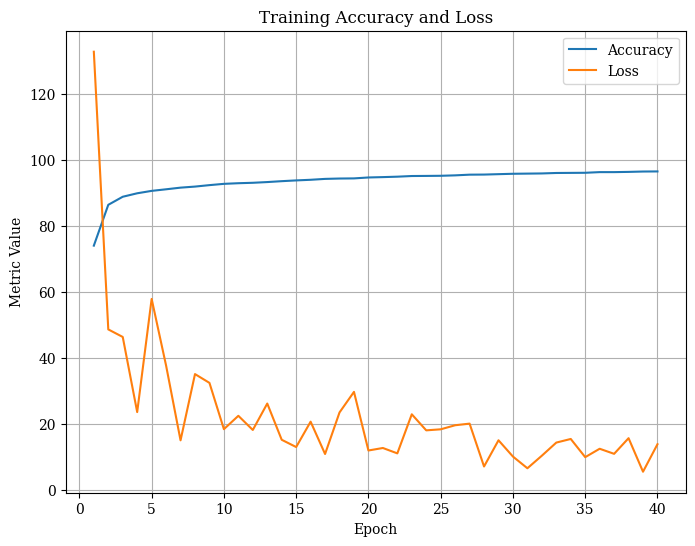

In [17]:
# Create the dataframe
df_metrics2 = pd.DataFrame({'Epoch': range(1, num_epochs + 1), 
                   'Accuracy': accuracy_history2,
                   'Loss': loss_history2})

# Plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(df_metrics2['Epoch'], df_metrics2['Accuracy'], label='Accuracy')
plt.plot(df_metrics2['Epoch'], df_metrics2['Loss']*100, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.grid(True) 
plt.show()